In [1]:
import pandas as pd

In [2]:
train = pd.read_csv('dataset_st.csv',index_col = 0)

In [3]:
import lightgbm as lgb
from sklearn import datasets
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.metrics import roc_auc_score, accuracy_score

X_train, X_test, y_train, y_test = train_test_split(dataset, datalabel, test_size=0.3)

train_data = lgb.Dataset(X_train, label=y_train)
validation_data = lgb.Dataset(X_test, label=y_test)

In [4]:
del_feature = ['ts_code', 'label']
features = [i for i in train.columns if i not in del_feature]

## Convert the label to two categories
train_x = train[features]
train_y = train['label'].values

In [5]:
train2 = pd.read_csv('dataset_st.csv',index_col = 0)
data_label = train2.pop('label')
tscode = train2.pop('ts_code')

In [6]:
X_train, X_test, y_train, y_test = train_test_split(train2, data_label, test_size=0.2)

train_data = lgb.Dataset(X_train, label=y_train)
validation_data = lgb.Dataset(X_test, label=y_test)

In [7]:
params = {'num_leaves': 90, #结果对最终效果影响较大，越大值越好，太大会出现过拟合
          'objective': 'binary', #定义的目标函数
          'max_depth': -1,
          'learning_rate':  1,
          "min_sum_hessian_in_leaf": 4,
          "boosting": "gbdt",
          "feature_fraction": 0.8,  #提取的特征比率
          "bagging_freq": 1,
          "bagging_fraction": 0.8,
          "bagging_seed": 11,
          "lambda_l1": 0.1,             #l1正则
          "verbosity": -1,
          "nthread": -1,          
          'metric': {'binary_logloss', 'auc'},  ##评价函数选择
          }
clf = lgb.train(params,
                    train_data,
                    valid_sets=[validation_data])

[1]	valid_0's binary_logloss: 0.534868	valid_0's auc: 0.727053
[2]	valid_0's binary_logloss: 0.762607	valid_0's auc: 0.565217
[3]	valid_0's binary_logloss: 0.736112	valid_0's auc: 0.560386
[4]	valid_0's binary_logloss: 0.843265	valid_0's auc: 0.5
[5]	valid_0's binary_logloss: 0.922205	valid_0's auc: 0.466184
[6]	valid_0's binary_logloss: 0.862171	valid_0's auc: 0.463768
[7]	valid_0's binary_logloss: 0.915219	valid_0's auc: 0.439614
[8]	valid_0's binary_logloss: 0.811841	valid_0's auc: 0.463768
[9]	valid_0's binary_logloss: 0.878667	valid_0's auc: 0.487923
[10]	valid_0's binary_logloss: 0.916365	valid_0's auc: 0.502415
[11]	valid_0's binary_logloss: 0.942017	valid_0's auc: 0.463768
[12]	valid_0's binary_logloss: 1.01085	valid_0's auc: 0.458937
[13]	valid_0's binary_logloss: 1.04503	valid_0's auc: 0.468599
[14]	valid_0's binary_logloss: 1.04216	valid_0's auc: 0.458937
[15]	valid_0's binary_logloss: 0.911953	valid_0's auc: 0.478261
[16]	valid_0's binary_logloss: 0.891191	valid_0's auc: 0.

In [8]:
y_pred = clf.predict(X_test)
def xl(x):
    if(x>0.2):
        return 1
    else:
        return 0

In [9]:
from sklearn.metrics import confusion_matrix

In [10]:
y_pred = clf.predict(X_test)
y_pred = [xl(x) for x in y_pred]
print(y_pred)
print(accuracy_score(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

[0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1]
0.6875
[[18  5]
 [ 5  4]]


In [15]:
params = {'num_leaves': 60, #结果对最终效果影响较大，越大值越好，太大会出现过拟合
          'min_data_in_leaf': 20,
          'objective': 'binary', #定义的目标函数
          'max_depth': 7,
          'num_leaves' : 32,
          'learning_rate': 0.03,
          "min_sum_hessian_in_leaf": 4,
          "boosting": "gbdt",
          "feature_fraction": 0.9,  #提取的特征比率
          "bagging_freq": 1,
          "bagging_fraction": 0.8,
          "bagging_seed": 11,
          "lambda_l1": 0.1,             #l1正则
          "verbosity": -1,
          "nthread": -1,          
          'metric': {'binary_logloss', 'auc'},  ##评价函数选择
          "random_state": 2019, #随机数种子，可以防止每次运行的结果不一致
          }

folds = KFold(n_splits=5, shuffle=True, random_state=2019)
prob_oof = np.zeros((train_x.shape[0], ))

## train and predict
feature_importance_df = pd.DataFrame()
for fold_, (trn_idx, val_idx) in enumerate(folds.split(train)):
    print("fold {}".format(fold_ + 1))
    trn_data = lgb.Dataset(train_x.iloc[trn_idx], label=train_y[trn_idx])
    val_data = lgb.Dataset(train_x.iloc[val_idx], label=train_y[val_idx])


    clf = lgb.train(params,
                    trn_data,
                    valid_sets=[trn_data, val_data],
                    verbose_eval=20,
                    early_stopping_rounds=60)
    prob_oof[val_idx] = clf.predict(train_x.iloc[val_idx], num_iteration=clf.best_iteration)

    fold_importance_df = pd.DataFrame()
    fold_importance_df["Feature"] = features
    fold_importance_df["importance"] = clf.feature_importance()
    fold_importance_df["fold"] = fold_ + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)

fold 1
Training until validation scores don't improve for 60 rounds
[20]	training's auc: 0.866113	training's binary_logloss: 0.533865	valid_1's auc: 0.65873	valid_1's binary_logloss: 0.683493
[40]	training's auc: 0.902244	training's binary_logloss: 0.484346	valid_1's auc: 0.674603	valid_1's binary_logloss: 0.675738
[60]	training's auc: 0.918561	training's binary_logloss: 0.446689	valid_1's auc: 0.65873	valid_1's binary_logloss: 0.691504
[80]	training's auc: 0.92701	training's binary_logloss: 0.417116	valid_1's auc: 0.650794	valid_1's binary_logloss: 0.705651
Early stopping, best iteration is:
[35]	training's auc: 0.894376	training's binary_logloss: 0.495902	valid_1's auc: 0.678571	valid_1's binary_logloss: 0.681031
fold 2
Training until validation scores don't improve for 60 rounds
[20]	training's auc: 0.870893	training's binary_logloss: 0.547215	valid_1's auc: 0.591787	valid_1's binary_logloss: 0.604449
[40]	training's auc: 0.885816	training's binary_logloss: 0.494373	valid_1's auc: 0

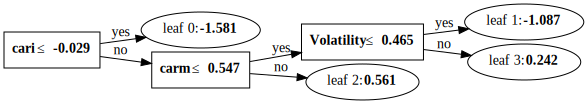

In [11]:
import os
os.environ["PATH"] += os.pathsep + 'C:/Program Files/Graphviz/bin'
 
lgb.create_tree_digraph(clf,tree_index = 0)

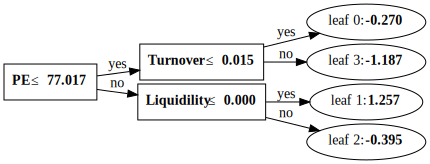

In [12]:
lgb.create_tree_digraph(clf,tree_index = 1)

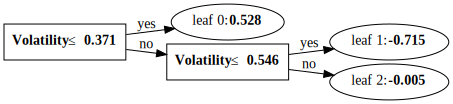

In [13]:
lgb.create_tree_digraph(clf,tree_index = 2)

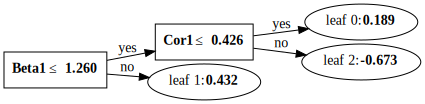

In [43]:
lgb.create_tree_digraph(clf,tree_index = 3)

In [23]:
clf.save_model('model.txt')

In [21]:
import lightgbm as lgb
from sklearn import datasets
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.metrics import roc_auc_score, accuracy_score

# 加载数据
iris = datasets.load_iris()

# 划分训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(iris.data, iris.target, test_size=0.3)

# 转换为Dataset数据格式
train_data = lgb.Dataset(X_train, label=y_train)
validation_data = lgb.Dataset(X_test, label=y_test)

# 参数
params = {
    'learning_rate': 0.1,
    'lambda_l1': 0.1,
    'lambda_l2': 0.2,
    'max_depth': 4,
    'objective': 'multiclass',  # 目标函数
    'num_class': 3,
}

# 模型训练
gbm = lgb.train(params, train_data, valid_sets=[validation_data])

# 模型预测
y_pred = gbm.predict(X_test)


LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[25]	valid_0's multi_logloss: 0.134911
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[26]	valid_0's multi_logloss: 0.131023
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[27]	valid_0's multi_logloss: 0.127879
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[28]	valid_0's multi_logloss: 0.12488
[LightGBM] [Warning] 

In [ ]:
y_pred = [list(x).index(max(x)) for x in y_pred]
print(y_pred)

# 模型评估
print(accuracy_score(y_test, y_pred))